In [179]:
# Import libraries
import pandas as pd
import numpy as np
import warnings 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from string import ascii_letters
#import plotly.express as px
import sys
import gc
import pickle
import time

In [180]:
# Import Data
df_sales = pd.read_csv('sales_train.csv')
df_shops = pd.read_csv('shops.csv')
df_test = pd.read_csv('test.csv')
df_items = pd.read_csv('items.csv')
df_item_cats = pd.read_csv('item_categories.csv')

In [181]:
# View data
print('Sales dataset: ')
print(df_sales.head(15))

print('Test set: ')
print(df_test.head(15))

Sales dataset: 
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0   02.01.2013               0       59    22154      999.00           1.0
1   03.01.2013               0       25     2552      899.00           1.0
2   05.01.2013               0       25     2552      899.00          -1.0
3   06.01.2013               0       25     2554     1709.05           1.0
4   15.01.2013               0       25     2555     1099.00           1.0
5   10.01.2013               0       25     2564      349.00           1.0
6   02.01.2013               0       25     2565      549.00           1.0
7   04.01.2013               0       25     2572      239.00           1.0
8   11.01.2013               0       25     2572      299.00           1.0
9   03.01.2013               0       25     2573      299.00           3.0
10  03.01.2013               0       25     2574      399.00           2.0
11  05.01.2013               0       25     2574      399.00           1.0
12  07.01

<AxesSubplot:xlabel='item_cnt_day'>

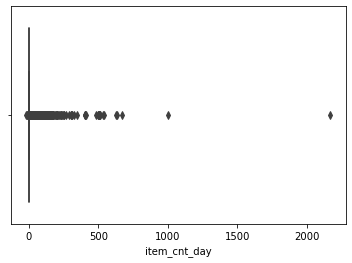

In [182]:
# Initial EDA

# Check for outliers

sns.boxplot(x=df_sales.item_cnt_day) # Some items sell way more than other items - possible outlier

<AxesSubplot:xlabel='item_price'>

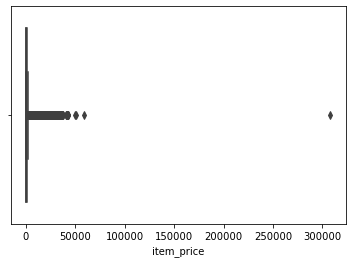

In [183]:
sns.boxplot(x=df_sales.item_price) # Some item prices seems like outliers - 300000?

In [184]:
print(df_shops[df_shops.shop_id.isin([0, 57])]['shop_name'])
print(df_shops[df_shops.shop_id.isin([1, 58])]['shop_name'])
print(df_shops[df_shops.shop_id.isin([40, 39])]['shop_name']) # Shop names look similar 

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


In [185]:
# Process outliers
df_train = df_sales[(df_sales.item_price < 100000) & (df_sales.item_price > 0)]
df_train = df_train[df_sales.item_cnt_day < 1001]
df_train['test_data'] = 0
df_test['test_data'] = 1

df_train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,test_data
0,02.01.2013,0,59,22154,999.00,1.0,0
1,03.01.2013,0,25,2552,899.00,1.0,0
2,05.01.2013,0,25,2552,899.00,-1.0,0
3,06.01.2013,0,25,2554,1709.05,1.0,0
4,15.01.2013,0,25,2555,1099.00,1.0,0


In [186]:
# Renumbering repeat shop names with same shop IDs
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57

df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58

df_train.loc[df_train.shop_id == 40, 'shop_id'] = 39
df_test.loc[df_test.shop_id == 40, 'shop_id'] = 39

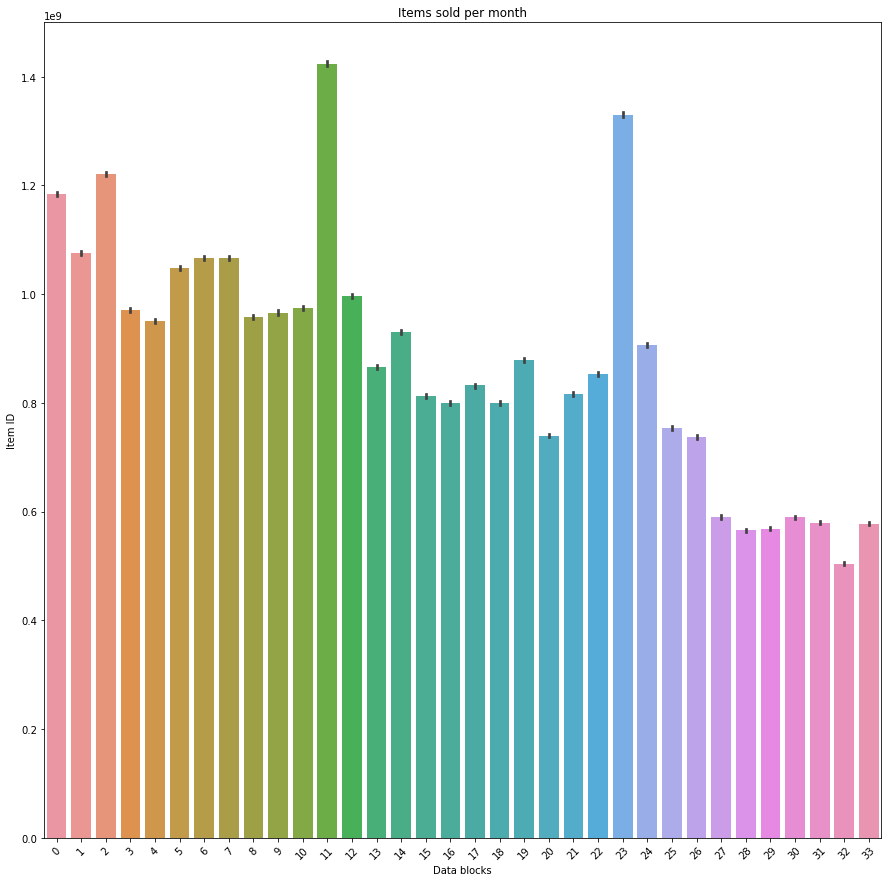

In [187]:
# Plots

plt.figure(figsize=(15,15))
plt.title('Items sold per month')
ax = sns.barplot(x='date_block_num',y='item_id',data = df_train,estimator = np.sum)
ax = ax.set(xlabel='Data blocks', ylabel = 'Item ID')
plt.xticks(rotation=45)
plt.show()

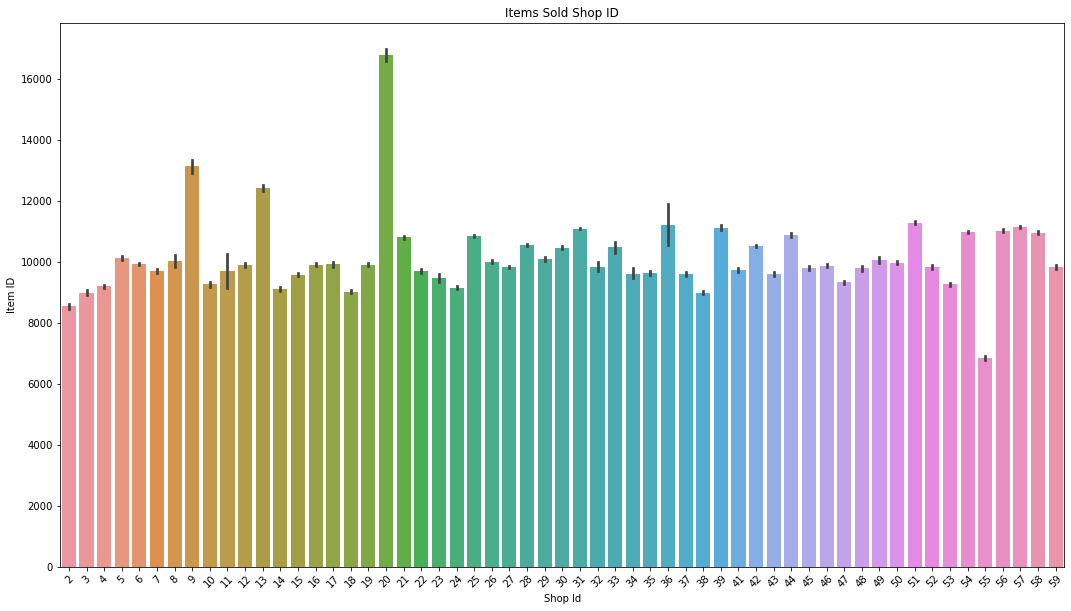

In [188]:
plt.figure(figsize = (18,10))
plt.title('Items Sold Shop ID')
ax = sns.barplot(x='shop_id', y="item_id", data=df_train, estimator=np.mean)
ax = ax.set(xlabel='Shop Id', ylabel='Item ID')
plt.xticks(rotation=45)
plt.show() 

In [189]:
# Group block numbers
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = []
for block_num in df_train['date_block_num'].unique():
    cur_shops = df_train.loc[df_sales['date_block_num']
                          == block_num, 'shop_id'].unique()
    cur_items = df_train.loc[df_sales['date_block_num']
                          == block_num, 'item_id'].unique()
    df.append(
        np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns=index_cols, dtype=np.int32)

In [190]:
# Add monthly sales according to block number
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                        .fillna(0)
                        .clip(0, 20)
                        .astype(np.float16))

In [191]:
# Add test dataset
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)

df_test = df_test.drop(columns=['ID'])
df = pd.concat([df, df_test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)

In [192]:
from sklearn.preprocessing import LabelEncoder

# Add city code feature
df_shops['city'] = df_shops['shop_name'].apply(lambda x: x.split()[0].lower())
df_shops.loc[df_shops.city == '!якутск', 'city'] = 'якутск'
df_shops['city_code'] = LabelEncoder().fit_transform(df_shops['city'])

coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

df_shops['city_coord_1'] = df_shops['city'].apply(lambda x: coords[x][0])
df_shops['city_coord_2'] = df_shops['city'].apply(lambda x: coords[x][1])
df_shops['country_part'] = df_shops['city'].apply(lambda x: coords[x][2])

df_shops = df_shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]
df = pd.merge(df, df_shops, on=['shop_id'], how='left')


In [193]:
# Add item category feature
map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

df_items = pd.merge(df_items, df_item_cats, on='item_category_id')

df_items['item_category'] = df_items['item_category_name'].apply(lambda x: x.split('-')[0])
df_items['item_category'] = df_items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
df_items['item_category_common'] = LabelEncoder().fit_transform(df_items['item_category'])

df_items['item_category_code'] = LabelEncoder().fit_transform(df_items['item_category_name'])
df_items = df_items[['item_id', 'item_category_common', 'item_category_code']]
df = pd.merge(df, df_items, on=['item_id'], how='left')

In [194]:
import calendar
# Add weekend feature 
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

In [195]:
# Add interaction feature
# Item first appears in which block
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

# Items, shop first appear in which block
first_shop_item_buy_block = df[df['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [196]:
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

# Item was sold before this block
df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)
 
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 

In [197]:
del first_item_block
del first_shop_item_buy_block

In [198]:
#  Add lag feature
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

# Add sales lags for last 3 months
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')

In [199]:
# Add avg shop/item price

index_cols = ['shop_id', 'item_id', 'date_block_num']
group = df_train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")

df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = df_train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)

In [200]:
#Add target encoding for item/city for last 3 months

item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.drop(['item_loc_target_enc'], axis=1, inplace=True)

In [201]:
#Add target encoding for item/shop for last 3 months

 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_shop_target_enc')
df.drop(['item_shop_target_enc'], axis=1, inplace=True)

In [202]:
# For new items add avg category sales for last 3 months

#For new items add avg category sales for last 3 months
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)

In [203]:
# For new items, add avg category sales in a separate store for last 3 months

item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

df['new_item_shop_cat_avg'] = (df['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_shop_cat_avg')
df.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)

In [204]:
# Add sales for the last three months for similar item (item with id = item_id +- 1)

def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')
def lag_feature_adv2(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv2']
        shifted['date_block_num'] += i
        shifted['item_id'] += 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv2'] = df[col+'_lag_'+str(i)+'_adv2'].astype('float16')
    return df

df = lag_feature_adv2(df, [1, 2, 3], 'item_cnt_month')

In [205]:
# Delete first three month data delete shop id 9, 20 from train datset(testdata don't exist)

df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df = df[(df['shop_id'] != 9)]
df = df[(df['shop_id'] != 20)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,test_data,city_code,city_coord_1,city_coord_2,country_part,item_category_common,...,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,item_cnt_month_lag_1_adv2,item_cnt_month_lag_2_adv2,item_cnt_month_lag_3_adv2
1122795,25,8092,3,3.0,0.0,13,55.75222,37.61556,1,11,...,0.293945,1.996094,1.446289,0.891113,7.0,5.0,13.0,0.0,0.0,0.0
1122796,25,7850,3,3.0,0.0,13,55.75222,37.61556,1,8,...,1.126953,4.867188,0.898438,1.947266,0.0,0.0,0.0,0.0,0.0,3.0
1122797,25,8051,3,3.0,0.0,13,55.75222,37.61556,1,14,...,0.160645,0.000000,0.416748,1.019531,0.0,0.0,0.0,0.0,0.0,0.0
1122798,25,8088,3,1.0,0.0,13,55.75222,37.61556,1,13,...,0.208130,1.000000,0.303955,0.534668,0.0,1.0,0.0,0.0,0.0,0.0
1122799,25,8089,3,1.0,0.0,13,55.75222,37.61556,1,13,...,0.208130,1.000000,0.303955,0.534668,2.0,0.0,3.0,1.0,1.0,0.0


In [206]:
# Save dataframe to memory
df.to_pickle('df.pkl')

In [207]:
# Read dataframe from memory
df = pd.read_pickle('df.pkl')

# Split master dataframe to train and test based on 'test_data' value
df_train = df.loc[df['test_data'] == 0]
df_test = df.loc[df['test_data'] == 1]

# Drop 'test_data' column before training 
df_train.drop(['test_data'], axis = 1, inplace = True)
df_test.drop(['test_data'], axis = 1, inplace = True)

df_test.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,item_cnt_month_lag_1_adv2,item_cnt_month_lag_2_adv2,item_cnt_month_lag_3_adv2
10842077,5,5037,34,0.0,3,59.2239,39.88398,2,5,19,...,0.305664,0.25,2.833984,0.166626,0.0,0.0,1.0,0.0,0.0,0.0
10842078,5,5320,34,0.0,3,59.2239,39.88398,2,13,55,...,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,3.0,2.0
10842079,5,5233,34,0.0,3,59.2239,39.88398,2,5,19,...,0.305664,0.25,2.833984,0.166626,0.0,0.0,0.0,0.0,0.0,1.0
10842080,5,5232,34,0.0,3,59.2239,39.88398,2,5,23,...,0.643066,0.00,1.799805,0.571289,1.0,3.0,1.0,0.0,0.0,0.0
10842081,5,5268,34,0.0,3,59.2239,39.88398,2,5,20,...,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [208]:
'''X_train = df_train[df_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df_train[df_train.date_block_num < 33]['item_cnt_month']
X_valid = df_train[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df_train[df_train.date_block_num == 33]['item_cnt_month']
X_test = df_test[df_test.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df'''

X_train = df_train[df_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df_train[df_train.date_block_num < 33]['item_cnt_month']
X_valid = df_train[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df_train[df_train.date_block_num == 33]['item_cnt_month']

X_test = df_test.drop(['item_cnt_month'], axis=1)
del df

In [209]:
# Train a lightgbm model
import lightgbm as lgb
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 8 -1,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}
feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3695
[LightGBM] [Info] Number of data points in the train set: 9454927, number of used features: 37
[LightGBM] [Info] Start training from score 0.295870
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 1.09691	valid_1's rmse: 0.971915
[100]	training's rmse: 1.01757	valid_1's rmse: 0.909121
[150]	training's rmse: 0.962708	valid_1's rmse: 0.868315
[200]	training's rmse: 0.925171	valid_1's rmse: 0.842061
[250]	training's rmse: 0.898481	valid_1's rmse: 0.826173
[300]	training's rmse: 0.879317	valid_1's rmse: 0.816139
[350]	training's rmse: 0.865078	valid_1's rmse: 0.809429
[400]	training's rmse: 0.853511	valid_1's rmse: 0.805107
[450]	training's rmse: 0.844275	valid_1's rmse: 0.802144
[500]	training's 

In [210]:
# Predict sales on test dataset
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": X_test.index-X_test.index[0], 
    "item_cnt_month": Y_test
})

# Save results to CSV file for Kaggle submission
submission.to_csv('kaggle_submission_v3.csv', index=False)